In [1]:
from sklearn import datasets
import numpy as np
import random
%matplotlib inline

In [2]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [ ]:
V = np.array([[6.775, 3.052, 5.647, 2.054],
 [5.889, 2.761, 4.364, 1.397],
 [5.004, 3.403, 1.485, 0.252]])

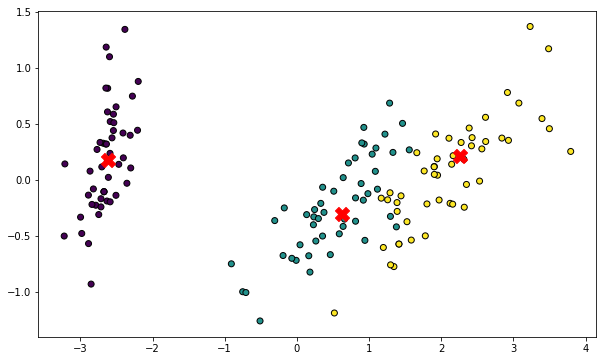

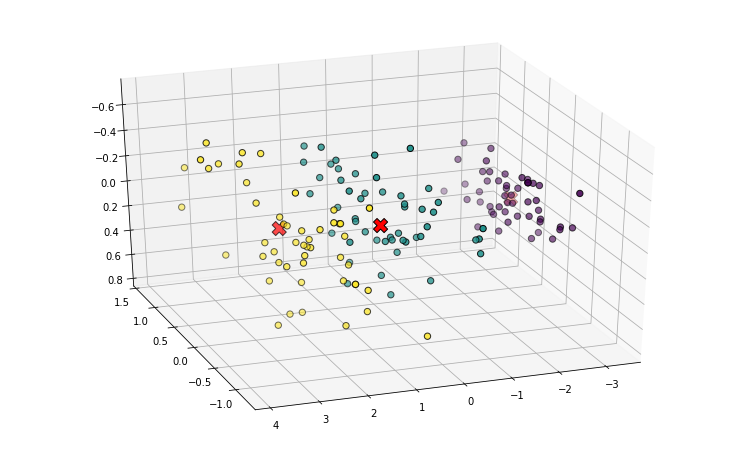

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()
pca_2d = PCA(n_components=2).fit(iris.data)

X_2d = pca_2d.transform(iris.data)
y = iris.target

centroids_2d = pca_2d.transform(V)

plt.figure(2, figsize=(10, 6))
plt.clf()
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], marker='X', c='red', s=200)

#3 pca's
fig = plt.figure(1, figsize=(10, 6))
ax = Axes3D(fig, elev=-150, azim=110)
pca_3d = PCA(n_components=3).fit(iris.data)
X_reduced = pca_3d.transform(iris.data)

centroids_3d = pca_3d.transform(V)

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis', edgecolor='k', s=40)
ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], c='red', marker='X' ,edgecolor='k', s=200)
plt.show()

In [3]:
def getInitializedPartitionMatrix(N,c):
    U = np.zeros((N, c))
    
    for i in range(N):
        sum = 0;
        for j in range(c-1):
            U[i][j] = (random.random()/c);
            sum += U[i][j];
    
        U[i][c-1] = 1 - sum;
    return U;

def checkMembershipCondition(U):
    return len(U.sum(axis=1)==1)==N;

def evaluateTerminationCriterion(U, V, X, m):
    norm_vals = np.zeros((U.shape[0], U.shape[1]))
    for i in range(len(V)):
        norm_vals[:,i] = np.power(np.linalg.norm(X-V[i], axis=1), 2)
    
    fitness_val = (np.power(U,m)*norm_vals).sum()
    #print('fitness_val:',fitness_val)
    return fitness_val;

In [4]:
N = X.shape[0]
F = X.shape[1]
epsilon = 0.01
m = 2
c_min = 2 
c_max = 3
C = [i for i in range(c_min, c_max+1)]

In [5]:
def FCM(N,c,m):
    U = getInitializedPartitionMatrix(N,c) 
    exp_val = -2/(m-1)
    U_n = np.copy(U)
    iter=0
    condition = True
    J_n = 1000
    
    while(condition and iter<100):
        iter+=1
        V = []
        U_n1 = np.zeros((N, c))    
        
        for i in range(c):
            col = np.power(U_n[:,i], m)
            v_i = (col.reshape(N,-1)*X).sum(axis=0)/col.sum()
            V.append(v_i)

        V = np.array(V)

        for i in range(len(V)):
            U_n1[:,i] = np.power(np.linalg.norm(X-V[i],axis=1), exp_val)

        U_n1 = U_n1/U_n1.sum(axis=1).reshape(150,-1)
        
        J_n1 = evaluateTerminationCriterion(U_n1, V, X, m)
        condition = (abs(J_n - J_n1) > epsilon) #end when J changes less than 0.001
        
        U_n = np.copy(U_n1)        
        J_n = np.copy(J_n1)
        
    #print('Iterations count for C[i]=',c,'is: ', iter)
    count.append(iter)
    return U_n, V;

In [431]:
U_n1, V = FCM(N,3,m)

Iterations count for C[i]= 3 is:  11


In [15]:
checkMembershipCondition(U_n1)

True

In [6]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [8]:
def getDispersion(c,X,V):
    N = X.shape[0]
    F = X.shape[1]
    coeff_variation = X.std(axis=0)/X.mean(axis=0)

    cluster_wise_std = np.zeros((c,F))
    for i in range(len(V)):
        cluster_wise_std[i,:] = np.power(np.power(X-V[i],2).sum(axis=0)/N, 0.5)

    cluster_wise_coeff_variation = cluster_wise_std/V

    Dispersion = cluster_wise_coeff_variation.max()/coeff_variation.max() 
    return Dispersion;

def getSeparation(c, U):
    similarity_matrix = np.zeros((c, c))
    for i in range(c):
        for j in range(i+1,c):
            similarity_matrix[i,j] = np.minimum(U[:,i], U[:,j]).max()
            similarity_matrix[j,i] = np.copy(similarity_matrix[i,j])

    separation_measure = 1 - similarity_matrix
    overall_separation = separation_measure.min()
    return overall_separation;

def getOverlap(c, U):
    N = U.shape[0]
    overlap_matrix = np.zeros((c, c))
    for i in range(c):
        for j in range(i+1,c):
            dom_min = np.minimum(U[:,i],U[:,j])
            dom_max = np.maximum(U[:,i],U[:,j])
            pt_wise_overlap = np.zeros((N,1))

            for k in range(len(dom_min)):
                if(dom_min[k]!=0 and dom_max[k]!=1):
                    if(dom_max[k]>0.5):
                        pt_wise_overlap[k] = 0.9*(1-dom_max[k])*2
                    elif(dom_max[k]>=0.1):    
                        pt_wise_overlap[k] = 1

            overlap_matrix[i,j] = pt_wise_overlap.sum()
            overlap_matrix[j,i] = np.copy(overlap_matrix[i,j])
    
    total_overlap = overlap_matrix.max()
    return total_overlap;

In [9]:
N = X.shape[0]
F = X.shape[1]
epsilon = 0.01
m = 2
c_min = 2 
c_max = 3

In [10]:
def getOptimalClusterNumber(m):
    C = [i for i in range(c_min, c_max+1)]

    dispersion_row = []
    separation_row = []
    overlap_row = []

    for i in range(len(C)):
        U_ci = np.zeros((N,C[i]))
        V_ci = np.zeros((C[i],F))

        U_ci, V_ci = FCM(N,C[i],m)
        dispersion_row.append(getDispersion(C[i],X,V_ci))
        separation_row.append(getSeparation(C[i], U_ci))
        overlap_row.append(getOverlap(C[i], U_ci))

    dispersion_row = np.array(dispersion_row)    
    separation_row = np.array(separation_row)
    overlap_row = np.array(overlap_row)

    dispersion_row_normalized = dispersion_row/dispersion_row.max()
    separation_row_normalized = separation_row/separation_row.max()
    overlap_row_normalized = overlap_row/overlap_row.max()

    VI_dso_row = (dispersion_row_normalized/separation_row_normalized) + (overlap_row_normalized/separation_row_normalized)
    VI_dso_min = VI_dso_row.min()

    optimal_clusters = C[VI_dso_row.argmin()]
    #print('Optimal Clusters:',optimal_clusters)
    #print('VI_dso_min :',VI_dso_min)
    return VI_dso_min, optimal_clusters

In [586]:
getOptimalClusterNumber(1.529) #1.529

(1.0999897515455241, 2)

In [577]:
getOptimalClusterNumber(1.523)

(1.0974490836609596, 2)

In [251]:
'''
s = np.random.normal(mean_g, std_dev_g, 10000)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')
plt.show()
'''

"\ns = np.random.normal(mean_g, std_dev_g, 10000)\n\nimport matplotlib.pyplot as plt\ncount, bins, ignored = plt.hist(s, 30, normed=True)\nplt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *\n                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),\n          linewidth=2, color='r')\nplt.show()\n"

In [14]:
import math

def observationProcess(Q_g, q_bits, m_range, r_g):
    link = 0

    incr = (m_range[1]-m_range[0])/np.power(2,q_bits)
    sub_spaces = [m_range[0]+(i*incr) for i in range(np.power(2,q_bits)+1)]
    
    s_g = (r_g<=np.power(Q_g,2)).astype(int)
    bin_str = ''.join(s_g.astype(str))
    link = int(bin_str, 2)+1

    selected_sub_space = [sub_spaces[link-1], sub_spaces[link]]

    mean_g = (selected_sub_space[0]+selected_sub_space[1])/2

    std_dev_g = (selected_sub_space[1]-mean_g)/4 # so that sub space is covered in -4std to 4std
    m_g = np.random.normal(mean_g, std_dev_g, 1)[0]
    #print('selected_sub_space',selected_sub_space)
    return m_g, s_g;

def getUpdatedQBit(alpha_i, delta_theta):
    updated_val = (alpha_i*math.cos(delta_theta)) - (np.power(1-np.power(alpha_i,2), 0.5)*math.sin(delta_theta))
    
    if(updated_val < np.power(epsilon,0.5)):
        updated_val = np.power(epsilon,0.5)
    elif(updated_val > np.power(1-epsilon,0.5)):
        updated_val = np.power(1-epsilon,0.5)
    
    return updated_val;

def updateQBits(Q_g, F_g_best, F_l_best, s_global, s_g):
    if(F_g_best>F_l_best):
        for i in range(len(s_global)):
            if(s_g[i]==1 and s_global[i]==0):
                delta_theta = 0.03 * math.pi #reduces Q bit value
            else:
                delta_theta = 0
            Q_g[i] = getUpdatedQBit(Q_g[i], delta_theta)    
    else:
        for i in range(len(s_global)):
            if(s_g[i]==0 and s_global[i]==1):
                delta_theta = -0.03 * math.pi #Increases Q bit value
            else:
                delta_theta = 0
            Q_g[i] = getUpdatedQBit(Q_g[i], delta_theta)    
    return Q_g

In [24]:
def QIE_FCM():
    m_range = [1.5, 2.5]
    q_bits = 2
    Q_g = np.array([np.power(q_bits, -0.5) for i in range(q_bits)])
    r_g = [random.random() for i in range(q_bits)]

    s_global = np.array([0 for i in range(q_bits)])
    F_g_best = 1000
    F_l_best = 0
    max_generations = 500
    g = 1
    
    while(g<=max_generations):
        m_g, s_g = observationProcess(Q_g, q_bits, m_range, r_g)
        VI_dso_min, optimal_clusters = getOptimalClusterNumber(m_g)
        F_l_best = VI_dso_min
        xyz.append(F_l_best)
        local_best_params = [np.copy(m_g), np.copy(optimal_clusters)]

        updateQBits(Q_g, F_g_best, F_l_best, s_global, s_g)

        if(F_g_best > F_l_best):
            global_best_params = np.copy(local_best_params)
            F_g_best = np.copy(F_l_best)
            s_global = np.copy(s_g)
        g+=1
        
    return global_best_params;    

In [31]:
count = []
xyz = []
global_best_params = QIE_FCM()
print('m: ',global_best_params[0])
print('toal iter count: ',np.array(count).sum())

m:  1.63236750466
toal iter count:  10212


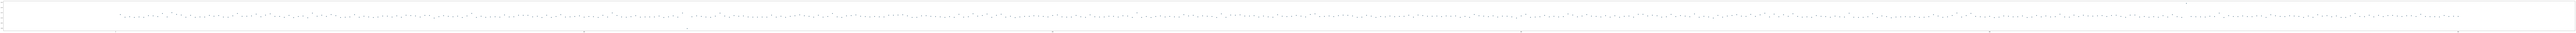

In [32]:
import matplotlib.pyplot as plt
plt.figure(2, figsize=(500, 6))
plt.clf()
plt.scatter(np.array([i for i in range(1,501)]), np.array(xyz), cmap='viridis', edgecolor='k')

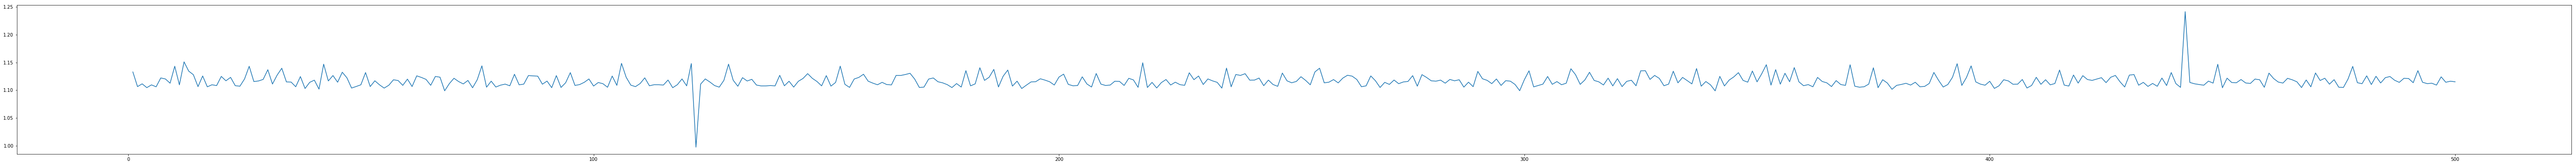

In [33]:
plt.figure(2, figsize=(100, 6))
plt.plot([i for i in range(1,501)], xyz)